In [29]:
#https://github.com/pomber/covid19
import numpy as np
import pandas as pd
from fbprophet import Prophet

import matplotlib.pyplot as plt
import datetime

In [30]:
df = pd.read_csv('data/corona19_world_data.csv', sep=',')
df['date'] = df['date'].astype('datetime64[ns]')

today = str(df.date.max().date())
tomorrow = str(df.date.max().date() + datetime.timedelta(days=1))
dayAfterTomorrow = str(df.date.max().date() + datetime.timedelta(days=2))
yesterday = str(df.date.max().date() - datetime.timedelta(days=1))

df[df['country']=='Brazil'].tail()

,country,date,cases,deaths,recoveries,day,case_day,death_day,recovery_day,%var_case_day,...,recoveries_million,avg7_cases,avg7_deaths,avg7_recoveries,avg7_cases_million,avg7_deaths_million,avg7_recoveries_million,perc_death,perc_recovery,active_cases
850,Brazil,2020-04-05,11130,486,127,40,770,41,0,-40.95,...,0.0,982.0,50.0,17.0,4.0,0.0,0.0,4.37,1.14,10517
851,Brazil,2020-04-06,12161,564,127,41,1031,78,0,33.90,...,0.0,1083.0,57.0,1.0,5.0,0.0,0.0,4.64,1.04,11470
852,Brazil,2020-04-07,14034,686,127,42,1873,122,0,81.67,...,0.0,1188.0,69.0,0.0,5.0,0.0,0.0,4.89,0.90,13221
853,Brazil,2020-04-08,16170,819,127,43,2136,133,0,14.04,...,0.0,1333.0,82.0,0.0,6.0,0.0,0.0,5.06,0.79,15224
854,Brazil,2020-04-09,18092,950,173,44,1922,131,46,-10.02,...,0.2,1435.0,89.0,6.0,6.0,0.0,0.0,5.25,0.96,16969


In [31]:
countries = df['country'].unique()
countries

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Diamond Princess', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala',
       'Guinea', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary',
       'Iceland', 'India

----------------------------
### Predicting cases and death for a selected country

#### selecting a country for prediction

In [32]:
#inform the countries for predictions
predictedCountries = ['Brazil','Italy', 'United Kingdom', 'Spain', 'US', 'China', 'France']

,country,ds,case_day,death_day,cases,deaths,predicted?
72,France,2020-04-05,2925,519,93773,8093,False
73,France,2020-04-06,5190,833,98963,8926,False
74,France,2020-04-07,11102,1417,110065,10343,False
75,France,2020-04-08,3894,544,113959,10887,False
76,France,2020-04-09,4822,1341,118781,12228,True
77,France,2020-04-10,6108,868,124889,13096,True
78,France,2020-04-11,8045,870,132934,13966,True
79,France,2020-04-12,5776,834,138710,14800,True
80,France,2020-04-13,6590,902,145300,15702,True
81,France,2020-04-14,7294,979,152594,16681,True


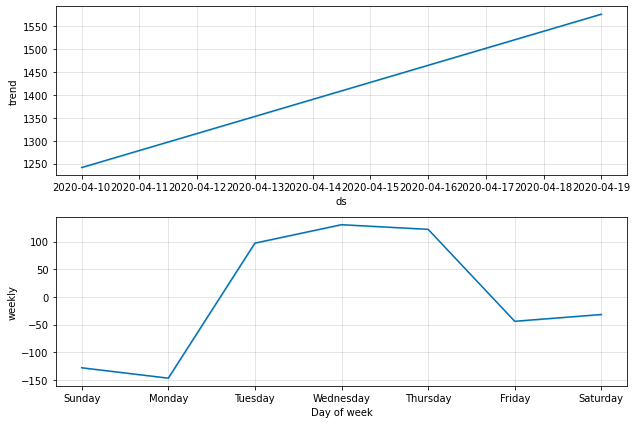

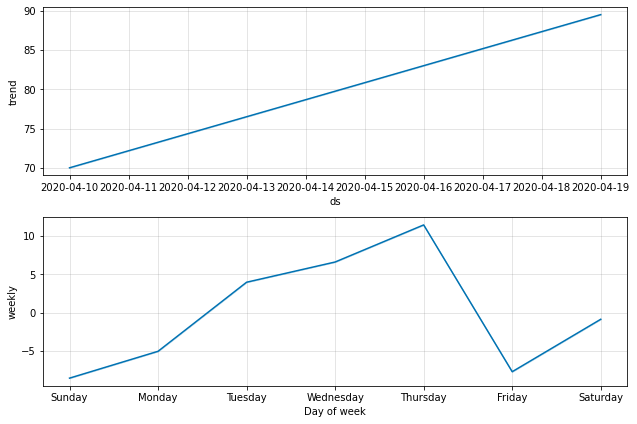

In [34]:
df_prediction = pd.DataFrame(columns=['country','ds', 'case_day', 'death_day', 'cases', 'deaths'])
daysToPredict = 10

for country in predictedCountries:
    # preparing dataset for predictions
    df_country = df.loc[df['country'] == country][['date','country','case_day','death_day']]
    df_country.rename(columns={'date': 'ds'}, inplace= True)
    df_cases = df_country.loc[:,['ds','case_day']]
    df_cases.rename(columns={'case_day':'y'}, inplace =True)

    df_deaths = df_country.loc[:,['ds','death_day']]
    df_deaths.rename(columns={'death_day':'y'}, inplace =True)
    
    # fiting the model and making prediction
    m_cases = Prophet(yearly_seasonality=False, daily_seasonality=False, interval_width=0.95, growth='linear')
    m_cases.fit(df_cases)
    m_deaths = Prophet(yearly_seasonality=False, daily_seasonality=False, interval_width=0.95, growth='linear')
    m_deaths.fit(df_deaths)
    
    future_cases = m_cases.make_future_dataframe(periods=daysToPredict, freq='D', include_history=False)
    future_deaths = m_deaths.make_future_dataframe(periods=daysToPredict, freq='D', include_history=False)
    
    forecast_cases = m_cases.predict(future_cases)
    forecast_deaths = m_deaths.predict(future_deaths)
    if country == 'Brazil':
        fig = m_cases.plot_components(forecast_cases)
        fig.savefig('predictions/brazil_prophet_cases.png')
        fig = m_deaths.plot_components(forecast_deaths)
        fig.savefig('predictions/brazil_prophet_deaths.png')
        
    p = forecast_cases.loc[:,['ds','yhat']]
    p.rename(columns={'yhat': 'y'}, inplace= True)
    t = df_cases.append(p[['ds','y']], ignore_index=True)
    
    p = forecast_deaths.loc[:,['ds','yhat']]
    p.rename(columns={'yhat': 'y'}, inplace= True)
    s = df_deaths.append(p[['ds','y']], ignore_index=True)

    t['ds'] = t['ds'].astype('datetime64[ns]')
    t.rename(columns={'y': 'case_day'}, inplace= True)
    t['case_day'] = t['case_day'].astype('int32')
    t['cases'] = t['case_day'].cumsum().astype('int32')
    t['death_day'] = s['y'].astype('int32')
    t['deaths'] = t['death_day'].cumsum().astype('int32')
    t['country'] = country
    t['predicted?'] = t['ds'] > today # para separar o que é previsão (True) do que é dado real (False)
    df_prediction = df_prediction.append(t)
    
df_prediction.to_csv('predictions/worldPredicion_' + today + '.csv', index = False)
df_prediction.tail(15)

In [35]:
df_prediction.loc[df_prediction['ds']==tomorrow]

,country,ds,case_day,death_day,cases,deaths,predicted?
44,Brazil,2020-04-10,1197,62,19289,1012,True
70,Italy,2020-04-10,6015,812,149641,19091,True
70,United Kingdom,2020-04-10,5315,400,71187,8393,True
69,Spain,2020-04-10,6696,873,159918,16320,True
79,US,2020-04-10,37376,707,498813,17185,True
79,China,2020-04-10,-464,-9,82419,3330,True
77,France,2020-04-10,6108,868,124889,13096,True


In [36]:
df_prediction.loc[df_prediction['ds']==dayAfterTomorrow]

,country,ds,case_day,death_day,cases,deaths,predicted?
45,Brazil,2020-04-11,1247,71,20536,1083,True
71,Italy,2020-04-11,5980,789,155621,19880,True
71,United Kingdom,2020-04-11,5312,413,76499,8806,True
70,Spain,2020-04-11,6916,902,166834,17222,True
80,US,2020-04-11,38771,730,537584,17915,True
80,China,2020-04-11,-797,10,81622,3340,True
78,France,2020-04-11,8045,870,132934,13966,True


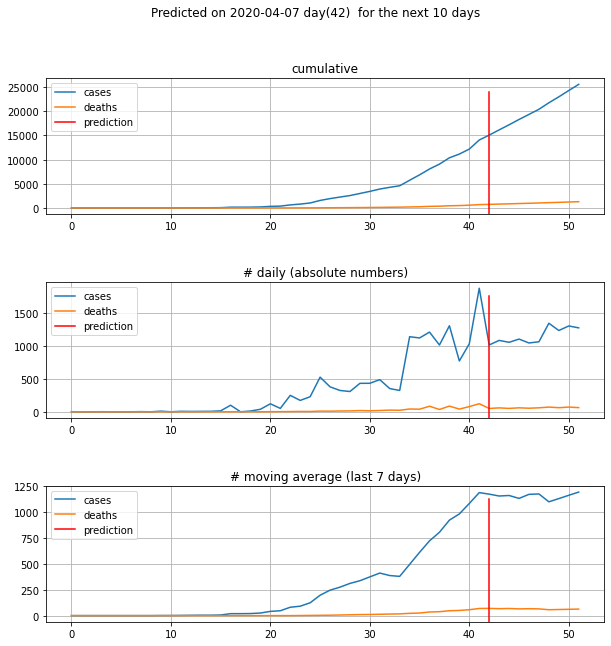

In [8]:
df_br = df_prediction.loc[df_prediction['country']=='Brazil']
df_br.reset_index(0, inplace=True)

x = df_br.index
corte = df_br.loc[df_br.ds == str(today)].index[0]+1

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10,10))
fig.suptitle('Predicted on ' + today + ' day('+ str(corte) +') ' + ' for the next ' + str(daysToPredict) + ' days')
fig.subplots_adjust(hspace = 0.5)
ax1.set_title('cumulative')
ax1.plot(x, df_br['cases'], label = 'cases')#, linewidths = 0.01)
ax1.plot(x, df_br['deaths'], label = 'deaths')
ax1.grid()
ax1.axvline(x=corte, ymin=0, ymax=0.9, color = 'red', label = 'prediction')
ax1.legend()

ax2.set_title('# daily (absolute numbers)')
ax2.plot(x, df_br['case_day'], label = 'cases')
ax2.plot(x, df_br['death_day'], label = 'deaths')
ax2.grid()
ax2.axvline(x=corte, ymin=0, ymax=0.9, color = 'red', label = 'prediction')
ax2.legend()

avg7_cases_million = df_br['case_day'].rolling(window=7).mean().replace([np.inf, -np.inf], 0).replace([np.nan], 0).astype('int')
avg7_death_million = df_br['death_day'].rolling(window=7).mean().replace([np.inf, -np.inf], 0).replace([np.nan], 0).astype('int')

ax3.set_title('# moving average (last 7 days)')
ax3.plot(x, avg7_cases_million, label = 'cases')
ax3.plot(x, avg7_death_million, label = 'deaths')
ax3.grid()
ax3.axvline(x=corte, ymin=0, ymax=0.9, color = 'red', label = 'prediction')
ax3.legend()

plt.savefig('predictions/brazil_predictions.png')

### Generating the markdown file

In [54]:
f = open('predictions/README.md', 'w')

readme = '# **Predictions**\n'
readme += "For experience, I'm running simple predictions over the cases and deaths per day. As they are time-series, I'm using [Facebook Prophet](https://facebook.github.io/prophet/docs/quick_start.html) that is also designed for this kind of prediction in a very simpler way. "
readme += "It works well for most of the time; sometimes there is a huge leap and it takes sometime more data to be understood.\n\n"
readme += 'These predictions were made with Covid19 pandemic data from **' + today + '**.\n\n'
readme += "As there are many countries to have their data predicted in a row, I selected a few of them plus Brazil to be predicted:\n"
readme += str(predictedCountries) + '.\n'
readme += '***Tip**: you can set yourself at the *[prediction.ipynb](../prediction.ipynb)* notebook which countries you prefer to predict*\n\n\n'

readme += '## The prediction\n'
readme += "As Facebook Prophet predicts time-series data and it is running the prediction over cases per day and deaths per day. After that, I compute theirs cumulatives.\
It is predicting for the next 10 days.\n"
readme += 'By the end, a CSV file containing all the predicted data is generated.\n\n'

readme += "#### The Brazil's last 5 days and predicted next 10 days\n"
readme += "*predicted? = True* means the line is a prediction; *=False* means they are real numbers.\n"
readme += df_prediction[df_prediction['country']=='Brazil'].tail(15).to_markdown()

readme += "\n\n #### The predicted Brazil's cumulative curves\n"
readme += "The prediction are over the daily data, so, here they were cumulated and plotted with the actual data:\n"
readme += '![](brazil_predictions.png)'

readme += "\n\nFacebook's Prophet automatically generates charts about the behaviour of the analysed and predicted data. That has a good visual information. Here are for the Brazil's prediction:\n"
readme += "### Cases\n"
readme += '![](brazil_prophet_cases.png)\n\n '
readme += "### Deaths\n"
readme += '![](brazil_prophet_deaths.png)\n'

readme += "#### Finally, the predictions for selected countries for:\n"
readme += '**Tomorrow**\n'
readme += df_prediction.loc[df_prediction['ds']==tomorrow].to_markdown()
readme += '\n\n **The day after tomorrow** \n'
readme += df_prediction.loc[df_prediction['ds']==dayAfterTomorrow].to_markdown()

f.write(readme)
f.close()
print('Predictions done!')

Predictions done!
